In [65]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors
sys.path.append('../neural_networks/mnist_cnn')
import mnistCnn

In [66]:
# load mnist dataset
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255

In [67]:
cnn = mnistCnn.MnistCnn()
cnn.loadWeights('../neural_networks/mnist_cnn/largerCnn30Epochs')
cnnLoss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)

(28, 28, 1)
(28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


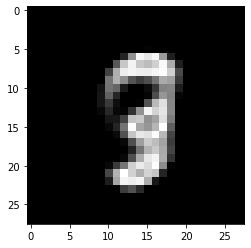

In [68]:
err = 1e-16
x_median = np.median(test_data, axis=0)
print(x_median.shape)
x_0 = test_data[0]
MAD = np.median(np.abs(test_data - x_median), axis = 0)
print(MAD.shape)
MAD_tf = tf.constant(tf.cast(np.expand_dims(MAD, 0), tf.float32))
print(MAD_tf.shape)
mask = tf.equal(MAD_tf, 0.0)
MAD_tf_err = tf.where(mask, tf.fill(MAD_tf.shape, err), MAD_tf)
print(MAD_tf_err.shape)
plt.imshow(MAD, cmap = 'gray', interpolation = 'none')

In [69]:
"""def dist_np(x_old, x_new):
    diff = np.abs(x_old - x_new)
    result = np.zeros_like(x_old, dtype = float)
    for i in range(x_old.shape[0]):
        for j in range(x_old.shape[1]):
            result[i][j] = diff[i][j] / np.maximum(MAD[i][j], 1e-16)
    result = np.sum(result)
    return result"""

'def dist_np(x_old, x_new):\n    diff = np.abs(x_old - x_new)\n    result = np.zeros_like(x_old, dtype = float)\n    for i in range(x_old.shape[0]):\n        for j in range(x_old.shape[1]):\n            result[i][j] = diff[i][j] / np.maximum(MAD[i][j], 1e-16)\n    result = np.sum(result)\n    return result'

In [70]:
@tf.function
def dist(x_old, x_new):
    diff = tf.math.abs(x_old - x_new)
    result = tf.math.divide(diff, MAD_tf_err)
    return tf.math.reduce_sum(result)

(1, 28, 28, 1)
(1, 28, 28, 1)
tf.Tensor(8.503922e+17, shape=(), dtype=float32)


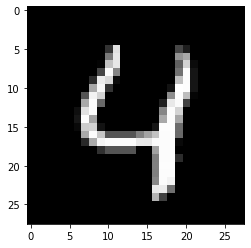

In [88]:
x_test1 = tf.Variable(tf.cast(np.expand_dims(test_data[4],0), tf.float32))
x_test2 = tf.Variable(tf.cast(np.expand_dims(test_data[1],0), tf.float32))
print(x_test1.shape)
print(x_test2.shape)
dist_test = dist(x_test1, x_test2)
print(dist_test)
plt.imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')

In [151]:
@tf.function
def target_function(x_old, x_new, y_new):
    unitVector = tf.reshape(tf.one_hot(indices = y_new, depth = 10), shape = (1,10)) #y_new as vector
    return -cnnLoss(cnn.model(x_new), unitVector) - dist(x_old, x_new)

@tf.function
def target_function_2(x_old, x_new, y_new):
    unitVector = tf.reshape(tf.one_hot(indices = y_new, depth = 10), shape = (1,10)) #y_new as vector
    return -tf.square(cnn.model(x_new) - unitVector) - dist(x_old, x_new)

In [152]:
def gen_counterfactual(x, y_old, y_new, cnn, max_iter = 600, max_change = 0.01):
    closeEnough = False
    iter = 0
    # x will not be changed
    # x_new will be changed
    #x_new = tf.Variable(tf.identity(x))
    x_new = tf.Variable(tf.cast(np.expand_dims(np.expand_dims(np.random.rand(28,28), -1), 0), tf.float32))
    while(not closeEnough and iter < max_iter):
        with tf.GradientTape() as tape:
            res = target_function_2(x, x_new, y_new)
        grad = tape.gradient(res, x_new)
        max_grad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(1.0, max_change/tf.maximum(max_grad, 1e-16))
        x_new.assign(x_new + (alpha * grad))
        x_new.assign(tf.clip_by_value(x_new, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        pred_new = tf.argmax(tf.squeeze(cnn.model(x_new))).numpy()
        if(pred_new == y_new):
            closeEnough = True
    print(iter)
    return x_new

4
1000
1000
1000
1000
1000
1000
1000
1
8


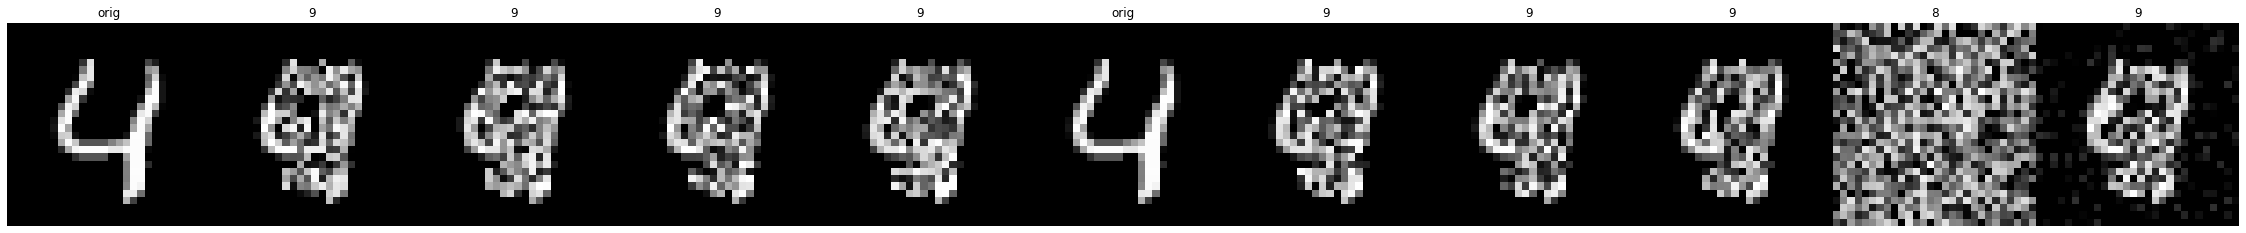

In [153]:
norm = colors.Normalize(vmin = 0, vmax = 1)
fig, ax = plt.subplots(1, 11, sharey = False, figsize = (40, 400))
y_test1 = y_test[4]
print(y_test1)
ax[0].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[0].set_title('orig')
ax[0].axis('off')
for i in range(10):
    if(y_test1 == i):
        ax[i+1].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
        ax[i+1].set_title('orig')
        ax[i+1].axis('off')
        continue
    counterfactual = gen_counterfactual(x = x_test1, y_old = y_test1, y_new = i, cnn = cnn, max_iter = 1000, max_change = 0.1)
    tempImg = ax[i+1].imshow(counterfactual[0,:,:,0], cmap = 'gray', interpolation = 'none')
    pred = tf.argmax(tf.squeeze(cnn.model(counterfactual))).numpy()
    ax[i+1].set_title(str(pred))
    tempImg.set_norm(norm)
    ax[i+1].axis('off')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4)

In [75]:
rand = np.expand_dims(np.expand_dims(np.random.rand(28,28), -1), 0)
print(rand.shape)

(1, 28, 28, 1)


7
[1.0865059e-02 1.8975981e-04 2.5250338e-04 3.5079158e-04 1.9409725e-02
 1.6367743e-04 7.5722736e-04 6.5909058e-04 3.7253916e-01 5.9481305e-01]
5


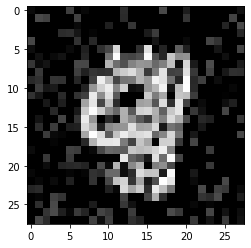

In [143]:
counterfactual_test = gen_counterfactual(x = x_test1, y_old = y_test1, y_new = 9, cnn = cnn, max_iter = 1000, max_change = 0.1)
pred_counterfactual_test = tf.squeeze(cnn.model(counterfactual_test)).numpy()
print(pred_counterfactual_test)
print(tf.argmin(pred_counterfactual_test).numpy())
img_test = plt.imshow(counterfactual_test[0,:,:,0], cmap = 'gray', interpolation = 'none')
img_test.set_norm(norm)